In [1]:
# Import all required modules
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import time
%matplotlib inline

In [2]:
# Read all the test images
test_images = []
fnames = glob.glob('./test_images/test*.jpg')

for fname in fnames:
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)

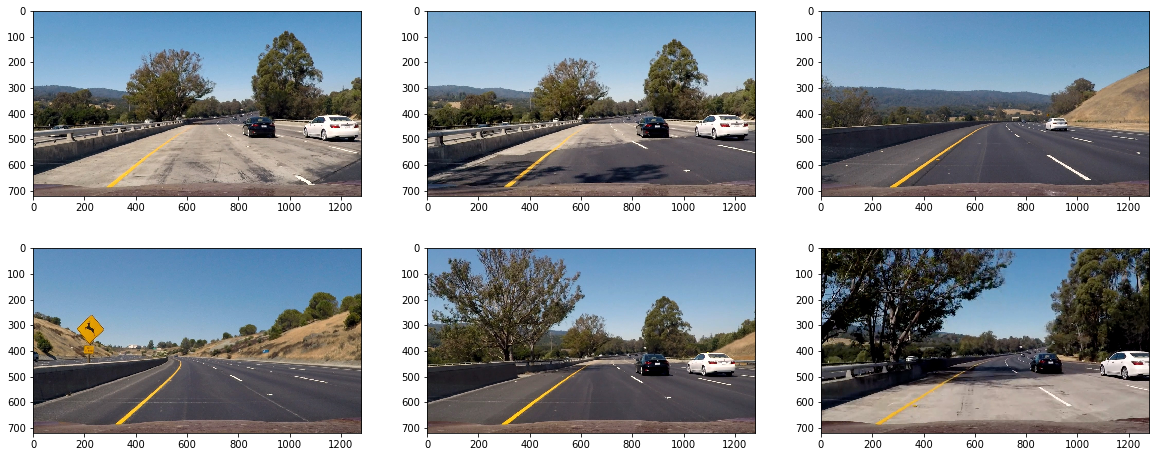

In [3]:
# Setting up a function to plot test images from a list like above
def plot_images(image_list):
    rows = 2
    cols = 3
    f,ax = plt.subplots(rows,cols,figsize=(20,int(13*rows/cols)))
    for i in range(len(image_list)):
        image = image_list[i]
        ax[int(i/cols),i%cols].imshow(image, cmap = 'gray')

# TEST
plot_images(test_images)

In [4]:
# Getting hog features, works only on single color channel image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
# Getting spatial features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [6]:
# Getting color histogram features
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
# Defining a function to extract features from a list of image paths to 
# create a list of feature vectors
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), hog_channel='ALL', orient=9, pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            feature_image = cv2.cvtColor(image, eval('cv2.COLOR_RGB2'+cspace))
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Apply get_hog_features() 
        if hog_channel == 'ALL': #This can be 0, 1, 2 or 'ALL'
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [8]:
# TEST
print('Testing the extract_features() function on the test images....')
features = extract_features(fnames)

print('Each of the extracted feature vectors has', len(features[0]), 'components.')

Testing the extract_features() function on the test images....
Each of the extracted feature vectors has 1531476 components.


In [9]:
# Defining a function that uses StandardScaler on the feature vectors 
# to scale them to zero mean and unit variance
def scale_features(features): # features is an output list from extract features
    # Create an array stack of feature vectors
    X = np.vstack((features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Return the scaled feature vectors
    return scaled_X, X_scaler

# TEST
print('Testing the scale_features() function on the test image features....')
scaled_features, s = scale_features(features)
print('Old mean:', np.mean(np.vstack((features)).astype(np.float64)))
print('New mean:', np.mean(scaled_features))
print('Old variance:', np.var(np.vstack((features)).astype(np.float64)))
print('New variance:', np.var(scaled_features))

Testing the scale_features() function on the test image features....
Old mean: 2.05646466488
New mean: -7.55944568594e-18
Old variance: 100964.070469
New variance: 0.999104132223


In [10]:
# Using the car_features and notcar_features, we form a dataset with labels that can be used for training an SVC
# car images have label 1 and notcar images have label 0
def form_data(car_features, notcar_features):
    feature_vectors = np.vstack((car_features, notcar_features)).astype(np.float64)
    feature_vectors, scaler = scale_features(feature_vectors)
    labels = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    return feature_vectors, labels, scaler

In [11]:
# Training and validating an SVC to classify cars and non-cars in an image 
def train_and_validate(feature_vectors, labels):
    # Shuffle the data
    feature_vectors, labels = shuffle(feature_vectors, labels)
    # Splitting data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.2, random_state=42)
    # Using a LinearSVC
    clf = LinearSVC()
    # Training time for SVC
    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t,2), 'Seconds to train SVC...')
    # Checking the accuracy score of the SVC
    print('Test accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
    return clf 

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, cspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
        ctrans_tosearch = cv2.cvtColor(img_tosearch, eval('cv2.COLOR_RGB2'+cspace))
    else: 
        ctrans_tosearch = img_tosearch

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Storing the positive detection coordinates
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(box)
                
    return draw_img, bbox_list
    

In [13]:
# Reading the car and not-car images 
# Non vehicle images
notcar_image_paths1 = glob.glob('./data/non-vehicles/Extras/extra*.png')
notcar_image_paths2 = glob.glob('./data/non-vehicles/GTI/image*.png')
non_vehicles = notcar_image_paths1 + notcar_image_paths2

# Vehicle images
car_image_paths1 = glob.glob('./data/vehicles/KITTI_extracted/*.png')
car_image_paths2 = glob.glob('./data/vehicles/GTI_Far/image*.png')
car_image_paths3 = glob.glob('./data/vehicles/GTI_Left/image*.png')
car_image_paths4 = glob.glob('./data/vehicles/GTI_MiddleClose/image*.png')
car_image_paths5 = glob.glob('./data/vehicles/GTI_Right/image*.png')
vehicles = car_image_paths1 + car_image_paths2 + car_image_paths3 + car_image_paths4 + car_image_paths5 

In [14]:
# Extracting features from the images
# Car features
car_features = extract_features(vehicles, cspace='YCrCb', spatial_size=(32,32))
print('We have', len(car_features), 'car and...')

# Not car features
notcar_features = extract_features(non_vehicles, cspace='YCrCb', spatial_size=(32,32))
print(len(notcar_features), 'non car datapoints')

print('with the following characteristics...')
print('Shape of image:', cv2.imread(vehicles[0]).shape)
print('Feature vector length:', len(car_features[0]))

We have 8792 car and...
8968 non car datapoints
with the following characteristics...
Shape of image: (64, 64, 3)
Feature vector length: 8460


In [15]:
# Forming our dataset
feature_vectors, labels, scaler = form_data(car_features, notcar_features)

print('We have a total of', feature_vectors.shape[0], 'with', feature_vectors.shape[1], 'component feature vector each.')

We have a total of 17760 with 8460 component feature vector each.


In [16]:
# Calling the train_and_validate() to train on the above feature vectors
svc = train_and_validate(feature_vectors, labels)

3.68 Seconds to train SVC...
Test accuracy of SVC =  0.9921


In [17]:
# Defining the parameters
cspace = 'YCrCb'
ystart = 350
ystop = 700
scales = [1.5, 2]
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
X_scaler = scaler
hist_bins = 32
hist_range = (0, 256)
hog_channel = 'ALL' # Can be 0, 1, 2 or 'ALL'

# Defining the data files
vehicles = vehicles
non_vehicles = non_vehicles

In [18]:
# Testing the car finding function on test images
detection_images = []

scale = 1.5

for image in test_images:
    detection_image, bbox_list = find_cars(image, cspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    detection_images.append(detection_image)

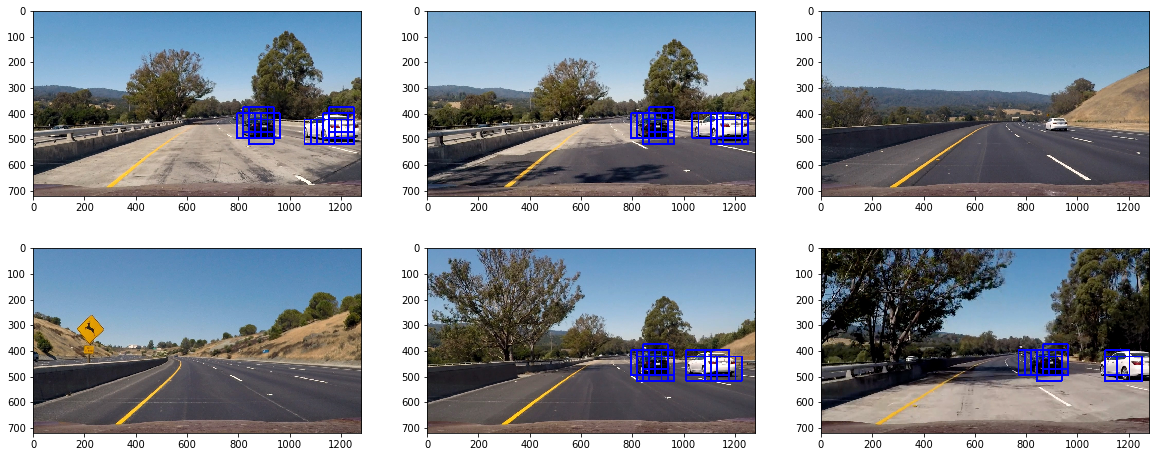

In [19]:
# Plotting detection images
plot_images(detection_images)

In [22]:
# Defining a single function that takes in our image paths, trains a SVC and returns the model and the scaler
def model(vehicles, non_vehicles, cspace, spatial_size, hist_bins, hist_range, 
                                    hog_channel, orient, pix_per_cell, cell_per_block):
    t1 = time.time()
    # Extract features
    car_features = extract_features(vehicles, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                                    hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
    noncar_features = extract_features(non_vehicles, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                                    hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
    # Form data set
    # Scale feature vectors and store the scaler
    feature_vectors, labels, scaler = form_data(car_features, noncar_features)
    # Train
    # Validate
    svc = train_and_validate(feature_vectors, labels)
    # Return the model and the scaler
    t2 = time.time()
    print('Time to run model():', round(t2-t1, 2))
    return svc, scaler

In [23]:
# Defining a single function that trains a SVC and uses sliding window technique
# on the test images
def test(test_images, vehicles, non_vehicles, cspace, spatial_size, hist_bins, hist_range, 
                                    hog_channel, orient, pix_per_cell, cell_per_block, ystart, ystop, scales):
    # Training and saving a SVC
    svc, scaler = model(vehicles, non_vehicles, cspace, spatial_size, hist_bins, hist_range, 
                                    hog_channel, orient, pix_per_cell, cell_per_block)
    # Storing detection images after running the sliding window search
    detection_images = []
    for image in test_images:
        t1 = time.time()
        for scale in scales:
            image, bbox_list = find_cars(image, cspace, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        t2 = time.time()
        detection_images.append(image)
        print('Time to find cars in one image:', round(t2-t1, 2))
    # Displyaing the detection images
    plot_images(detection_images)


In [24]:
# Defining the parameters
cspace = 'YCrCb'
ystart = 350
ystop = 700
scales = [1.5, 2]
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32
hist_range = (0, 256)
hog_channel = 'ALL' # Can be 0, 1, 2 or 'ALL'

# Defining the data files
vehicles = vehicles
non_vehicles = non_vehicles

5.48 Seconds to train SVC...
Test accuracy of SVC =  0.9935
Time to run model(): 72.85
Time to find cars in one image: 0.8
Time to find cars in one image: 0.72
Time to find cars in one image: 0.71
Time to find cars in one image: 0.71
Time to find cars in one image: 0.81
Time to find cars in one image: 0.71


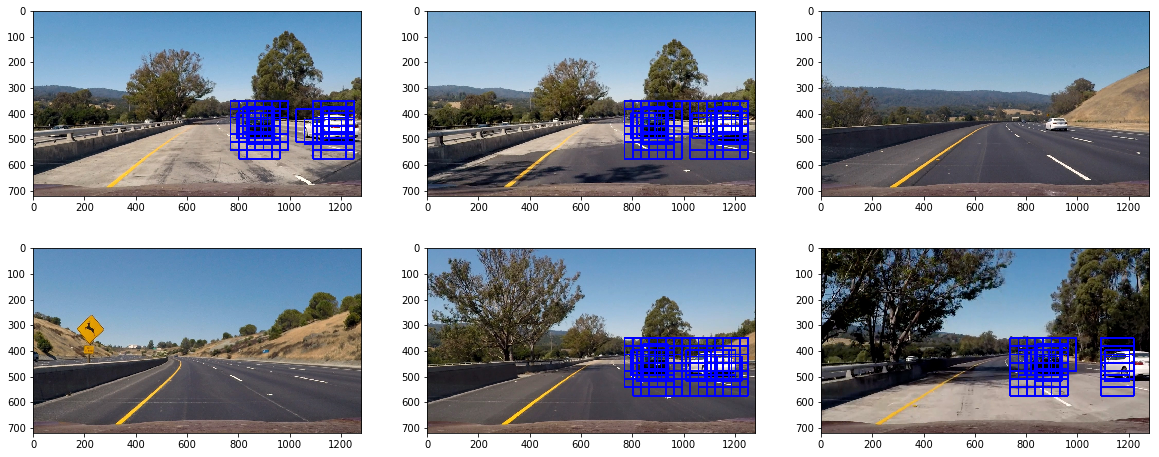

In [25]:
test(test_images, vehicles, non_vehicles, cspace, spatial_size, hist_bins, hist_range, 
                                    hog_channel, orient, pix_per_cell, cell_per_block, ystart, ystop, scales)

In [26]:
# Generating heatmap images to remove false positives and multiple detections
def add_heat(heatmap, bbox_list):
    # Iterating through list of boxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

In [27]:
# Applying thresholding to reject areas of false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [28]:
# Determining which box belongs to which car by identifying the number of 
# hot detections in the heatmap
from scipy.ndimage.measurements import label
def get_hots(heatmap):
    labels = label(heatmap)
    return labels

In [29]:
def get_labels(image):
    bbox_list = []
    for scale in scales:
        img, bboxes = find_cars(image, cspace, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bbox_list = bbox_list + bboxes
    print(len(bbox_list), 'boxes detected in the image.')
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, bbox_list)
    heatmap = apply_threshold(heatmap, 2)
    labels = get_hots(heatmap)
    return labels


In [31]:
labeled_images = []

for image in test_images:
    labels = get_labels(image)
    labeled_images.append(labels[0])
    print(labels[1], 'cars detected.')
    

24 boxes detected in the image.
2 cars detected.
23 boxes detected in the image.
2 cars detected.
0 boxes detected in the image.
0 cars detected.
0 boxes detected in the image.
0 cars detected.
21 boxes detected in the image.
2 cars detected.
15 boxes detected in the image.
2 cars detected.


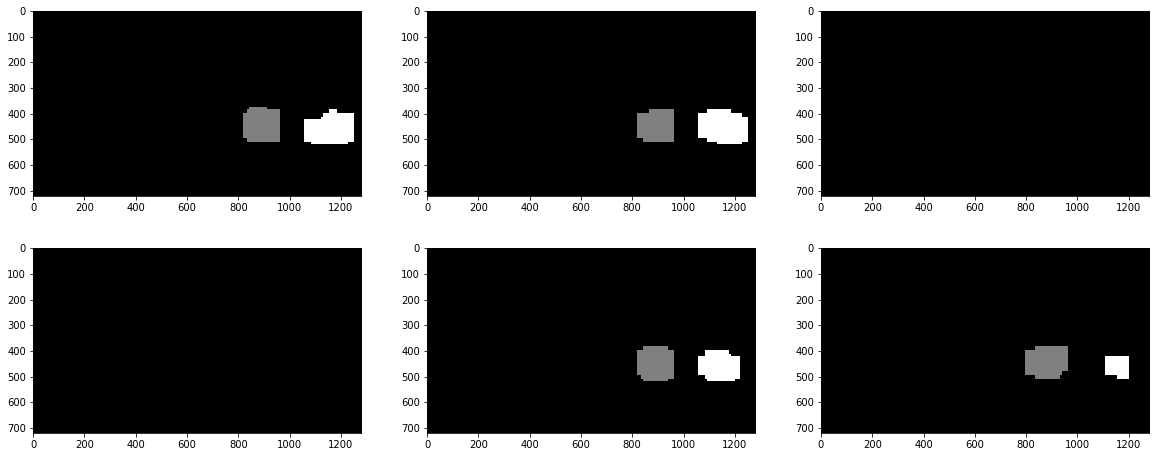

In [32]:
plot_images(labeled_images)

In [33]:
# Drawing bounding boxes around the thresholded detections
def draw_labeled_boxes(img, labels):
    # iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img


In [34]:
output_images = []

for image in test_images:
    labels = get_labels(image)
    print(labels[1])
    img = draw_labeled_boxes(image, labels)
    output_images.append(img)
    

24 boxes detected in the image.
2
23 boxes detected in the image.
2
0 boxes detected in the image.
0
0 boxes detected in the image.
0
21 boxes detected in the image.
2
15 boxes detected in the image.
2


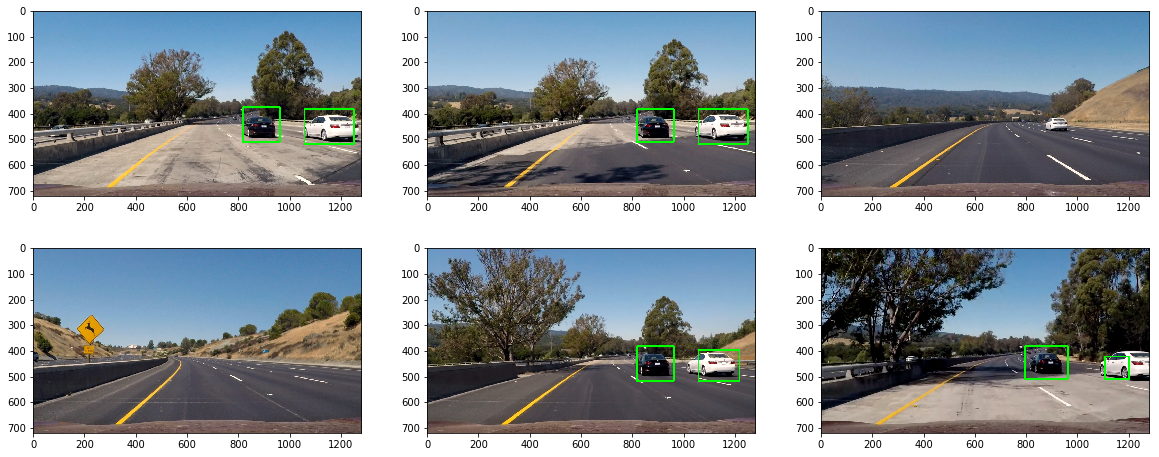

In [35]:
plot_images(output_images)